In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import os
import tqdm
from datetime import datetime
import json
from pandas.io.json import json_normalize
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew,kurtosis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [2]:
## Read Json format to df 
def load_df(csv_path='data/GA_CustomerRev_Predict/train.csv',nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df
    

In [53]:
train=load_df()
test=load_df('data/GA_CustomerRev_Predict/test.csv')

## Featuring Engineering

In [54]:
train['totals.transactionRevenue']=train['totals.transactionRevenue'].astype('float')

In [11]:
## Dropna with % more than threshold of 70%
def check_null(df):
    flag=df.isnull().sum().any()
    if flag==True:
        total=df.isnull().sum().sort_values(ascending=False)
        percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
        missing=pd.concat([total,percent],keys=['total','percent'],axis=1)
        
        data_type=[]
        for col in df.columns:
            dtype=df[col].dtype
            data_type.append(dtype)
        missing['type']=data_type
        return missing
    else:
        return False

In [14]:
check_null(train).head(15)

,total,percent,type
trafficSource.campaignCode,903652,0.999999,object
trafficSource.adContent,892707,0.987887,int64
totals.transactionRevenue,892138,0.987257,object
trafficSource.adwordsClickInfo.page,882193,0.976252,object
trafficSource.adwordsClickInfo.adNetworkType,882193,0.976252,object
trafficSource.adwordsClickInfo.slot,882193,0.976252,int64
trafficSource.adwordsClickInfo.isVideoAd,882193,0.976252,int64
trafficSource.adwordsClickInfo.gclId,882092,0.976140,int64
trafficSource.isTrueDirect,629648,0.696781,object
trafficSource.referralPath,572712,0.633774,object


In [55]:
def update_time(df):
    df['date']=df.date.apply(lambda x:pd.to_datetime(str(x),format='%Y-%m-%d'))
    df['weekday']=df.date.apply(lambda x:pd.Timestamp(x).weekday())
    df['day']=df.date.apply(lambda x:pd.Timestamp(x).day)
    df['month']=df.date.apply(lambda x:pd.Timestamp(x).month)
    df['year']=df.date.apply(lambda x:pd.Timestamp(x).year)
    df['visitorhour']=df.visitStartTime.apply(lambda x: datetime.fromtimestamp(x).hour)
    return df
train=update_time(train)

In [56]:
def fill_na(df):
    df.loc[:,'totals.pageviews']=df.loc[:,'totals.pageviews'].fillna(1).astype('int')
    df.loc[:,'totals.newVisits']=df.loc[:,'totals.newVisits'].fillna(0).astype('int')
    df.loc[:,'totals.bounces']=df.loc[:,'totals.bounces'].fillna(0).astype('int')
    df.loc[:,'totals.transactionRevenue']=df.loc[:,'totals.transactionRevenue'].fillna(0.0).astype('float')
    df.loc[:,'trafficSource.isTrueDirect']=df.loc[:,'trafficSource.isTrueDirect'].fillna(False)
    df.loc[:,'trafficSource.adwordsClickInfo.isVideoAd']=df.loc[:,'trafficSource.adwordsClickInfo.isVideoAd'].fillna(True)
    df.loc[df['geoNetwork.city']=='(not set)','geoNetwork.city']='Nan'
    df.loc[:,'trafficSource.campaignCode']=df.loc[:,'trafficSource.campaignCode'].fillna(0)
    df.loc[:,'trafficSource.adwordsClickInfo.page']=df.loc[:,'trafficSource.adwordsClickInfo.page'].fillna(0).astype('int')
    df.loc[:,'trafficSource.adwordsClickInfo.adNetworkType']=df.loc[:,'trafficSource.adwordsClickInfo.adNetworkType'].fillna(df['trafficSource.adwordsClickInfo.adNetworkType'].mode([0]))
    df.loc[:,'trafficSource.adwordsClickInfo.gclId']=df.loc[:,'trafficSource.adwordsClickInfo.gclId'].fillna(0)
    df.loc[:,'trafficSource.referralPath']=df.loc[:,'trafficSource.referralPath'].fillna(0)
    return df 
train=fill_na(train)

In [57]:
def numerical_cols(df):
    df['totals.hits']=df['totals.hits'].astype('int')
    return df 
train=numerical_cols(train)

In [60]:
train.drop(['trafficSource.campaignCode','trafficSource.adContent',
'trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.adNetworkType',
'trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.isVideoAd','trafficSource.adwordsClickInfo.gclId'],axis=1,inplace=True)

test.drop(['trafficSource.adContent',
'trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.adNetworkType',
'trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.isVideoAd','trafficSource.adwordsClickInfo.gclId'],axis=1,inplace=True)

In [61]:
## We can drop constant_cols 
const_cols=[c for c in train.columns if train[c].nunique(dropna=False)==1]
combine=[train,test]
for df in combine:
    df.drop(['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'trafficSource.adwordsClickInfo.criteriaParameters'],axis=1,inplace=True)
combine=[train,test]

In [10]:
## Identify 'not available in demo dataset' columns: 
not_aval_cols=[]
for col in train.columns:
    if (train[col]=='not available in demo dataset').any():
        not_aval_cols.append(col)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [62]:
def normalizing(df):
    scaler=StandardScaler()
    df['totals.hits']=pd.Series(scaler.fit_transform(df['totals.hits'].values.reshape(-1,1)).flatten())
    df['totals.transactionRevenue']=np.log1p(df['totals.transactionRevenue'])
    return df 
train=normalizing(train)

In [242]:
browser_rev=(train.groupby(['device.browser']).agg(['count','mean'])['totals.transactionRevenue']).sort_values(by=['count'],ascending=False).reset_index()
device_rev=(train.groupby(['device.deviceCategory']).agg(['count','mean'])['totals.transactionRevenue']).sort_values(by=['count'],ascending=False).reset_index()
operate_rev=train.groupby(['device.operatingSystem']).agg(['count','mean'])['totals.transactionRevenue'].sort_values(by=['count'],ascending=False).reset_index()

Text(0.5, 1.0, 'Rev Per OS')

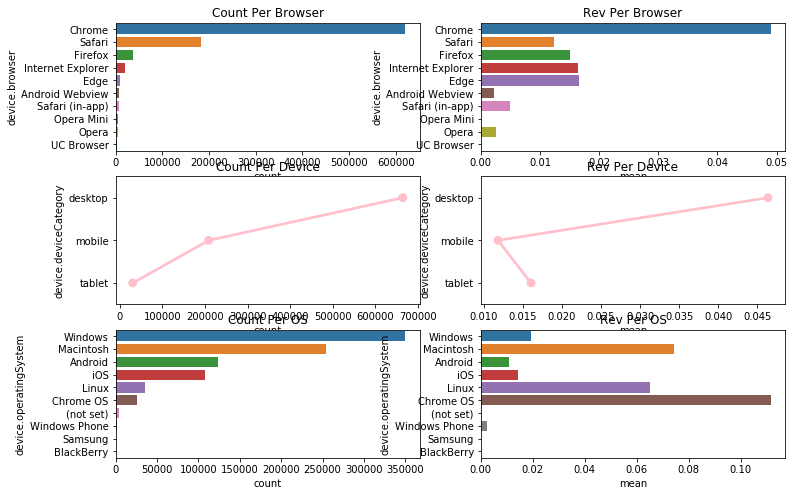

In [265]:
f,axes=plt.subplots(3,2,figsize=(12,8))
sns.barplot(browser_rev['count'].iloc[:10],browser_rev['device.browser'].iloc[:10],ax=axes[0][0]).set_title('Count Per Browser')
sns.barplot(browser_rev['mean'].iloc[:10],browser_rev['device.browser'].iloc[:10],ax=axes[0][1]).set_title('Rev Per Browser')
sns.pointplot(device_rev['count'],device_rev['device.deviceCategory'],ax=axes[1][0],color='pink').set_title('Count Per Device')
sns.pointplot(device_rev['mean'],device_rev['device.deviceCategory'],ax=axes[1][1],color='pink').set_title('Rev Per Device')
sns.barplot(operate_rev['count'].iloc[:10],operate_rev['device.operatingSystem'].iloc[:10],ax=axes[2][0]).set_title('Count Per OS')
sns.barplot(operate_rev['mean'].iloc[:10],operate_rev['device.operatingSystem'].iloc[:10],ax=axes[2][1]).set_title('Rev Per OS')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


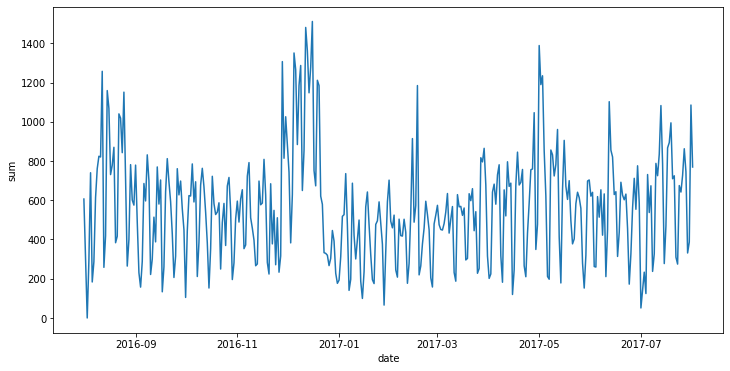

In [15]:
date_rev=train.groupby(['date']).agg(['count','sum'])['totals.transactionRevenue'].reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(date_rev.date,date_rev['sum'])

Text(0.5, 1.0, 'Rev Distplot')

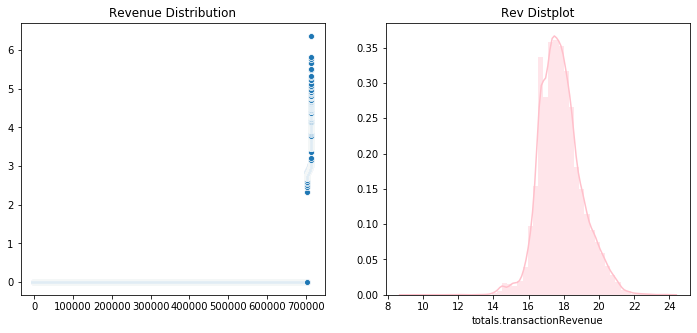

In [42]:
revenue=train.groupby(['fullVisitorId']).sum()['totals.transactionRevenue'].reset_index()
f,axes=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(range(revenue.shape[0]),np.sort(np.log1p(revenue['totals.transactionRevenue'])),ax=axes[0]).set_title('Revenue Distribution')
sns.distplot(train[train['totals.transactionRevenue']>0]['totals.transactionRevenue'],ax=axes[1],color='pink').set_title('Rev Distplot')

In [50]:
print('Kurtosis:{}'.format(kurtosis(train[train['totals.transactionRevenue']>0]['totals.transactionRevenue'])))
print('Skew:{}'.format(skew(train[train['totals.transactionRevenue']>0]['totals.transactionRevenue'])))

Kurtosis:1.1610188903215466
Skew:0.33752306602147514


In [11]:
def outliers(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    iqr=q3-q1
    cut_off=1.5*iqr
    lower,upper=q1-cut_off,q3+cut_off
    outlier=[x for x in df if x <lower or x >upper]
    remove_outlier=[x for x in df if x >lower or x <upper]
    print('Outliers identified: {}'.format(len(outlier)))
    print('Percentage of outliers: {}%'.format(len(outlier)/len(remove_outlier)))
    return pd.Series(outlier)
outlier_rev=outliers(train['totals.transactionRevenue'])

Outliers identified: 11515
Percentage of outliers: 1.0%


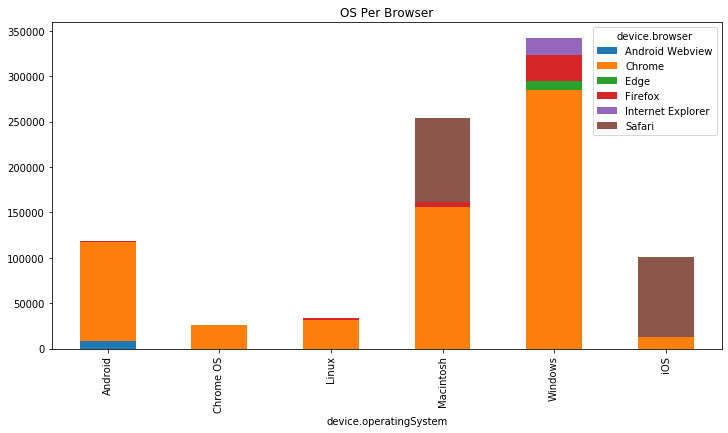

In [92]:
mask=train['device.operatingSystem'].isin(train['device.operatingSystem'].value_counts().iloc[:6].index)
mask2=train['device.browser'].isin(train['device.browser'].value_counts().iloc[:6].index)
pd.crosstab(train[mask]['device.operatingSystem'],train[mask2]['device.browser']).plot(kind='bar',stacked=True,figsize=(12,6),title='OS Per Browser')

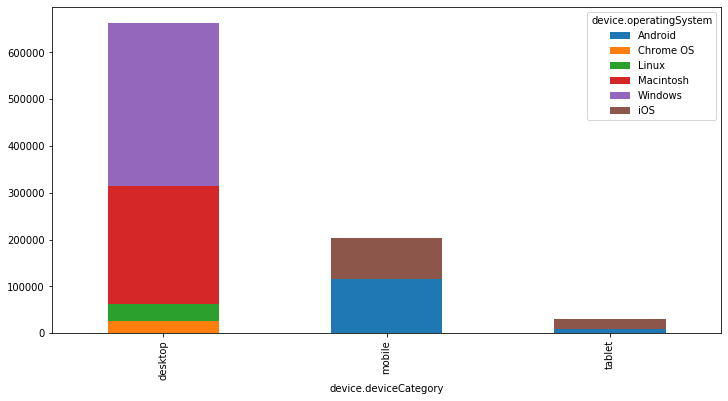

In [109]:
mask=train['device.operatingSystem'].isin(train.groupby(['device.operatingSystem']).count()['sessionId'].sort_values(ascending=False).iloc[:6].index)
pd.crosstab(train['device.deviceCategory'],train[mask]['device.operatingSystem']).plot(kind='bar',stacked=True,figsize=(12,6))

In [117]:
continent_rev=train.groupby(['geoNetwork.continent']).agg(['count','mean'])['totals.transactionRevenue'].sort_values(by=['count'],ascending=False).reset_index()
subcon_rev=train.groupby(['geoNetwork.subContinent']).agg(['count','mean'])['totals.transactionRevenue'].sort_values(by=['count'],ascending=False).reset_index().iloc[:10]
network_rev=train.groupby(['geoNetwork.networkDomain']).agg(['count','mean'])['totals.transactionRevenue'].sort_values(by=['count'],ascending=False).reset_index().iloc[:10]

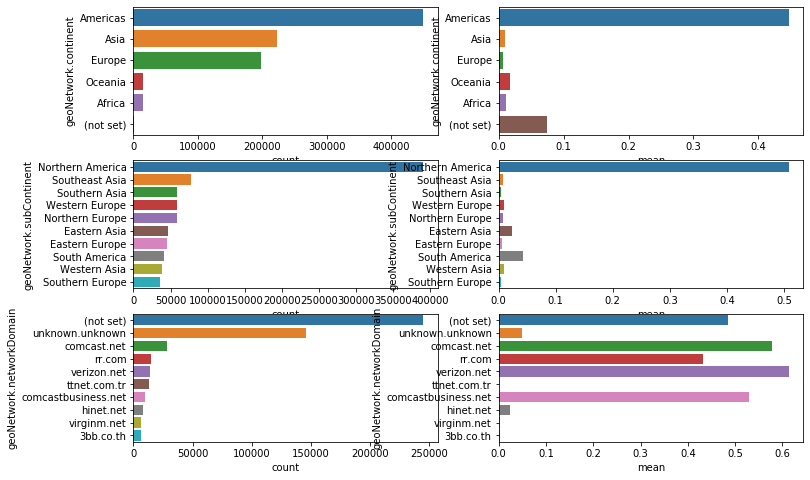

In [124]:
f,axes=plt.subplots(3,2,figsize=(12,8))
sns.barplot(continent_rev['count'],continent_rev['geoNetwork.continent'],ax=axes[0][0])
sns.barplot(continent_rev['mean'],continent_rev['geoNetwork.continent'],ax=axes[0][1])
sns.barplot(subcon_rev['count'],subcon_rev['geoNetwork.subContinent'],ax=axes[1][0])
sns.barplot(subcon_rev['mean'],subcon_rev['geoNetwork.subContinent'],ax=axes[1][1])
sns.barplot(network_rev['count'],network_rev['geoNetwork.networkDomain'],ax=axes[2][0])
sns.barplot(network_rev['mean'],network_rev['geoNetwork.networkDomain'],ax=axes[2][1])

In [130]:
source_rev=train.groupby(['trafficSource.source']).agg(['count','mean'])['totals.transactionRevenue'].sort_values(by=['count'],ascending=False).reset_index().iloc[:10]
medium=train.groupby(['trafficSource.medium']).agg(['count','mean'])['totals.transactionRevenue'].sort_values(by=['count'],ascending=False).reset_index()

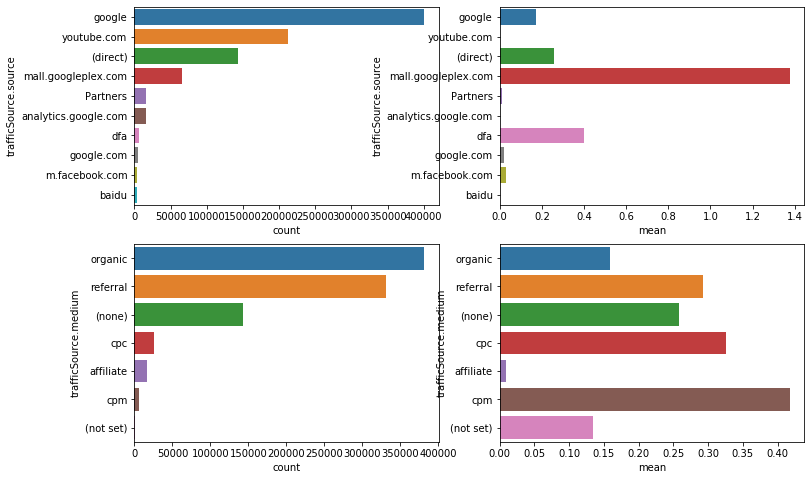

In [134]:
f,axes=plt.subplots(2,2,figsize=(12,8))
sns.barplot(source_rev['count'],source_rev['trafficSource.source'],ax=axes[0][0])
sns.barplot(source_rev['mean'],source_rev['trafficSource.source'],ax=axes[0][1])
sns.barplot(medium['count'],medium['trafficSource.medium'],ax=axes[1][0])
sns.barplot(medium['mean'],medium['trafficSource.medium'],ax=axes[1][1])

In [16]:
pageview_rev=train.groupby(['totals.pageviews']).agg(['count','mean'])['totals.transactionRevenue'].sort_values(by=['count'],ascending=False).reset_index()
hits_rev=train.groupby(['totals.hits']).agg(['count','mean'])['totals.transactionRevenue'].sort_values(by=['count'],ascending=False).reset_index()

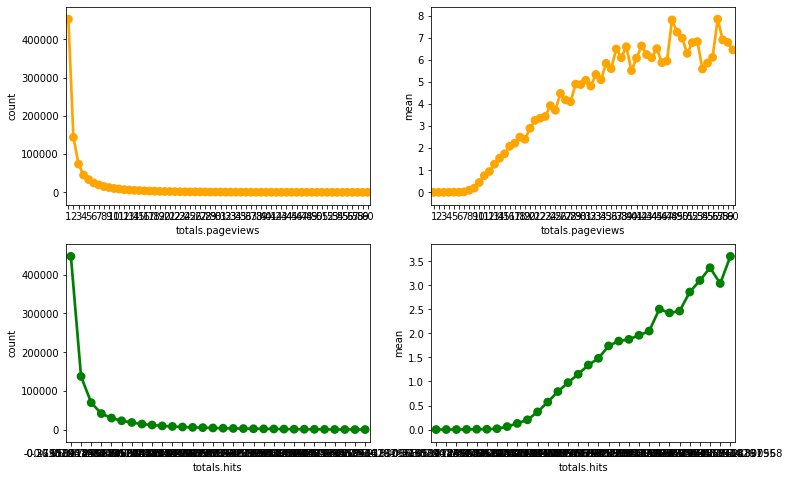

In [28]:
f,axes=plt.subplots(2,2,figsize=(12,8))
sns.pointplot(pageview_rev['totals.pageviews'].iloc[:60],pageview_rev['count'].iloc[:60],ax=axes[0][0],color='orange')
sns.pointplot(pageview_rev['totals.pageviews'].iloc[:60],pageview_rev['mean'].iloc[:60],ax=axes[0][1],color='orange')
sns.pointplot(hits_rev['totals.hits'].iloc[:30],hits_rev['count'].iloc[:30],ax=axes[1][0],color='green')
sns.pointplot(hits_rev['totals.hits'].iloc[:30],hits_rev['mean'].iloc[:30],ax=axes[1][1],color='green')

## Modelling 

In [43]:
set(train.columns).difference(set(test.columns))

{'day', 'month', 'totals.transactionRevenue', 'visitorhour', 'weekday', 'year'}

In [63]:
for df in combine:
    df.drop(['sessionId'],axis=1,inplace=True)
y=train['totals.transactionRevenue'].values
train.drop(['day', 'month', 'totals.transactionRevenue', 'visitorhour', 'weekday', 'year'],axis=1,inplace=True)

In [ ]:
train['fullVisitorId']=train.fullVisitorId.astype('int')
train['totals.visits']=train['totals.visits'].astype('int')
cat_features=train.select_dtypes(include=['object']).columns

In [92]:
def encode_features(train,test):
    features=cat_features
    df_combined=pd.concat([train[features],test[features]])
    for feature in features:
        le=LabelEncoder()
        le=le.fit(df_combined[feature].astype('str'))
        train[feature]=le.transform(train[feature].astype('str'))
        test[feature]=le.transform(test[feature].astype('str'))
    return train,test
train,test=encode_features(train,test)

In [107]:
for df in combine:
    df['device.isMobile']=np.where(df['device.isMobile']==True,1,0)
    df['trafficSource.isTrueDirect']=np.where(df['trafficSource.isTrueDirect']==True,1,0)

In [121]:
for df in combine:
    df.drop(['date'],axis=1,inplace=True)
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits'] 

for df in combine:
    for feature in num_cols:
        df[feature]=df[feature].astype('float')

In [136]:
X_train,X_val,y_train,y_val=train_test_split(train,y,test_size=0.3,random_state=0)

In [137]:
def run_lgb(X_train,y_train,X_val,y_val,test):
    params={"objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1  }
    lgtrain=lgb.Dataset(X_train,label=y_train)
    lgval=lgb.Dataset(X_val,label=y_val)
    model=lgb.train(params,lgtrain,1000,valid_sets=[lgval],early_stopping_rounds=100,verbose_eval=100)
    pred_test_y=model.predict(test,num_iteration=model.best_iteration)
    pred_val_y=model.predict(X_val,num_iteration=model.best_iteration)
    return pred_test_y,model,pred_val_y

In [138]:
pre_test_y,model,pred_val_y=run_lgb(X_train,y_train,X_val,y_val,test)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.62584
[200]	valid_0's rmse: 1.61874
[300]	valid_0's rmse: 1.61657
Early stopping, best iteration is:
[288]	valid_0's rmse: 1.61645


In [143]:
pred_val_y[pred_val_y<0]=0

In [150]:
val_pred_df=pd.DataFrame({'fullVisitorId':X_val['fullVisitorId'].values})
val_pred_df['transactionRevenue']=y_val
val_pred_df['PredictedtransactionRevenue']=np.expm1(pred_val_y)
val_pred_df=val_pred_df.groupby(['fullVisitorId'])['transactionRevenue','PredictedtransactionRevenue'].sum().reset_index()

In [163]:
np.sqrt(mean_squared_error(np.log1p(val_pred_df['transactionRevenue']),np.log1p(val_pred_df['PredictedtransactionRevenue'])))

1.0268541404145228

In [166]:
submission_df=pd.DataFrame({'fullVisitorId':test['fullVisitorId'].values})
pre_test_y[pre_test_y<0]=0
submission_df['PredictedLogRev']=np.expm1(pre_test_y)
submission_df=submission_df.groupby(['fullVisitorId']).sum().reset_index()
submission_df['PredictedLogRev']=np.log1p(submission_df['PredictedLogRev'])

In [177]:
submission_df.head()

,fullVisitorId,PredictedLogRev
0,0,0.000000
1,6,0.001762
2,8,0.000000
3,9,0.629991
4,13,0.107309
